**Note:** This code assumes you have already trained a model and have the test data (`X_test`, `y_test`), the model's predictions (`y_pred`), and the predicted probabilities (`y_pred_proba`). Please replace the placeholder variables with your actual variables.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder,OneHotEncoder,StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense
from sklearn.ensemble import RandomForestClassifier

2025-10-31 19:00:03.209955: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
df=pd.read_csv('Credit_Card_Dataset.csv')
df.head(5)

,Customer_ID,Age,Gender,Marital_Status,Education_Level,Employment_Status,Annual_Income,Credit_Score,Number_of_Credit_Lines,Credit_Utilization_Ratio,...,Total_Spend_Last_Year,Defaulted,CLV,Total_Transactions,Avg_Transaction_Amount,Max_Transaction_Amount,Min_Transaction_Amount,Fraud_Transactions,Unique_Merchant_Categories,Unique_Transaction_Cities
0,CUST_00001,59,Male,Married,PhD,Unemployed,41442,642,4,0.44,...,13997,0,57310,22,454.337273,1379.89,11.83,0,10,13
1,CUST_00002,49,Male,Divorced,High School,Unemployed,85992,665,7,0.52,...,27768,0,124494,22,378.365000,1939.47,7.00,1,8,13
2,CUST_00003,35,Male,Married,Bachelor,Employed,58420,683,8,0.88,...,17979,1,46180,10,437.929000,1712.14,1.92,0,7,9
3,CUST_00004,63,Male,Single,Bachelor,Employed,59733,674,7,0.40,...,13261,1,35120,23,540.463913,2095.41,16.57,0,9,15
4,CUST_00005,28,Female,Married,Master,Employed,69487,733,5,0.88,...,23562,1,24310,16,520.643750,2068.37,28.06,1,8,12


In [3]:
#Hacemos un copy del dataset
copy=df.copy()

In [4]:
print(copy.dtypes)
categorical_features = copy.select_dtypes(include='object').columns.tolist()
numerical_features = copy.select_dtypes(include=['int64', 'float64']).columns.tolist()

Customer_ID                      object
Age                               int64
Gender                           object
Marital_Status                   object
Education_Level                  object
Employment_Status                object
Annual_Income                     int64
Credit_Score                      int64
Number_of_Credit_Lines            int64
Credit_Utilization_Ratio        float64
Debt_To_Income_Ratio            float64
Number_of_Late_Payments           int64
Tenure_in_Years                   int64
Total_Transactions_Last_Year      int64
Total_Spend_Last_Year             int64
Defaulted                         int64
CLV                               int64
Total_Transactions                int64
Avg_Transaction_Amount          float64
Max_Transaction_Amount          float64
Min_Transaction_Amount          float64
Fraud_Transactions                int64
Unique_Merchant_Categories        int64
Unique_Transaction_Cities         int64
dtype: object


In [5]:
print(categorical_features)
print(numerical_features)

['Customer_ID', 'Gender', 'Marital_Status', 'Education_Level', 'Employment_Status']
['Age', 'Annual_Income', 'Credit_Score', 'Number_of_Credit_Lines', 'Credit_Utilization_Ratio', 'Debt_To_Income_Ratio', 'Number_of_Late_Payments', 'Tenure_in_Years', 'Total_Transactions_Last_Year', 'Total_Spend_Last_Year', 'Defaulted', 'CLV', 'Total_Transactions', 'Avg_Transaction_Amount', 'Max_Transaction_Amount', 'Min_Transaction_Amount', 'Fraud_Transactions', 'Unique_Merchant_Categories', 'Unique_Transaction_Cities']


In [6]:
# Granularidad
objects=df.select_dtypes(include=['object']).columns
numerics=df.select_dtypes(include=['number']).columns

n=len(df)

print(f'Objects: {len(objects)}. Numerics:{len(numerics)}.')

for column in df:
    nulls = df[column].isnull().sum()

    nulls_rel=100*nulls/n

    if column in objects:
        total_data = df[column].nunique()
        relatives = total_data/n

        value_counts=df[column].value_counts()
        mode = value_counts[0]
        repetitions = value_counts[0]
        relative_repetitions = round(100*repetitions/n)

        string = f'Column: {column}. Type: Category. Unique abs: {total_data}. Unique%: {relatives*100}. Mode: "{mode}" w/{repetitions} ({relative_repetitions}%). Nulls: {nulls}. Nulls%: {nulls_rel}%'

        if total_data <10:
            string +='\n    Cats granularity : \n'
            uniques=df[column].value_counts()
            for k, v in uniques.to_dict().items():
                string+=f'    Cat:{k}. Val: {v}. Rel:{100*v/n}\n'
    elif column in numerics:
        mean,median,std=df[column].mean(),df[column].median(),df[column].std()
        string=f'Column: {column}. Type: Numeric. Mean: {mean}. Median: {median}. \
        Std: {std}. Nulls: {nulls}. Nulls rel: {nulls_rel}%'

        if len(df[column].unique())==1:
            string+=f'WARNING: Constant. Val:{df[column].unique()}'

    else:
        continue

    print(string)
    print()

Objects: 5. Numerics:19.
Column: Customer_ID. Type: Category. Unique abs: 10000. Unique%: 100.0. Mode: "1" w/1 (0%). Nulls: 0. Nulls%: 0.0%

Column: Age. Type: Numeric. Mean: 45.1515. Median: 45.0.         Std: 14.083223404751726. Nulls: 0. Nulls rel: 0.0%

Column: Gender. Type: Category. Unique abs: 2. Unique%: 0.02. Mode: "5016" w/5016 (50%). Nulls: 0. Nulls%: 0.0%
    Cats granularity : 
    Cat:Female. Val: 5016. Rel:50.16
    Cat:Male. Val: 4984. Rel:49.84


Column: Marital_Status. Type: Category. Unique abs: 3. Unique%: 0.03. Mode: "4901" w/4901 (49%). Nulls: 0. Nulls%: 0.0%
    Cats granularity : 
    Cat:Married. Val: 4901. Rel:49.01
    Cat:Single. Val: 4080. Rel:40.8
    Cat:Divorced. Val: 1019. Rel:10.19


Column: Education_Level. Type: Category. Unique abs: 4. Unique%: 0.04. Mode: "4060" w/4060 (41%). Nulls: 0. Nulls%: 0.0%
    Cats granularity : 
    Cat:Bachelor. Val: 4060. Rel:40.6
    Cat:High School. Val: 2954. Rel:29.54
    Cat:Master. Val: 2006. Rel:20.06
    Cat:PhD

/var/folders/bs/x01s4n69311dylwpb3yzhx6w0000gn/T/ipykernel_44858/3034265456.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  mode = value_counts[0]
/var/folders/bs/x01s4n69311dylwpb3yzhx6w0000gn/T/ipykernel_44858/3034265456.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  repetitions = value_counts[0]
/var/folders/bs/x01s4n69311dylwpb3yzhx6w0000gn/T/ipykernel_44858/3034265456.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]

In [7]:
#Nos deshacemos de los ID
id='Customer_ID'
#Definimos las variables de interés
response_of_interest='Defaulted'
bins=5

/var/folders/bs/x01s4n69311dylwpb3yzhx6w0000gn/T/ipykernel_44858/1945392643.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  values=copy.groupby(grouper).agg({response_of_interest:['mean','median','count']})[response_of_interest]
/var/folders/bs/x01s4n69311dylwpb3yzhx6w0000gn/T/ipykernel_44858/1945392643.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  values=copy.groupby(grouper).agg({response_of_interest:['mean','median','count']})[response_of_interest]
/var/folders/bs/x01s4n69311dylwpb3yzhx6w0000gn/T/ipykernel_44858/1945392643.py:25: FutureWarning: The default of observed=False is deprecated and wi

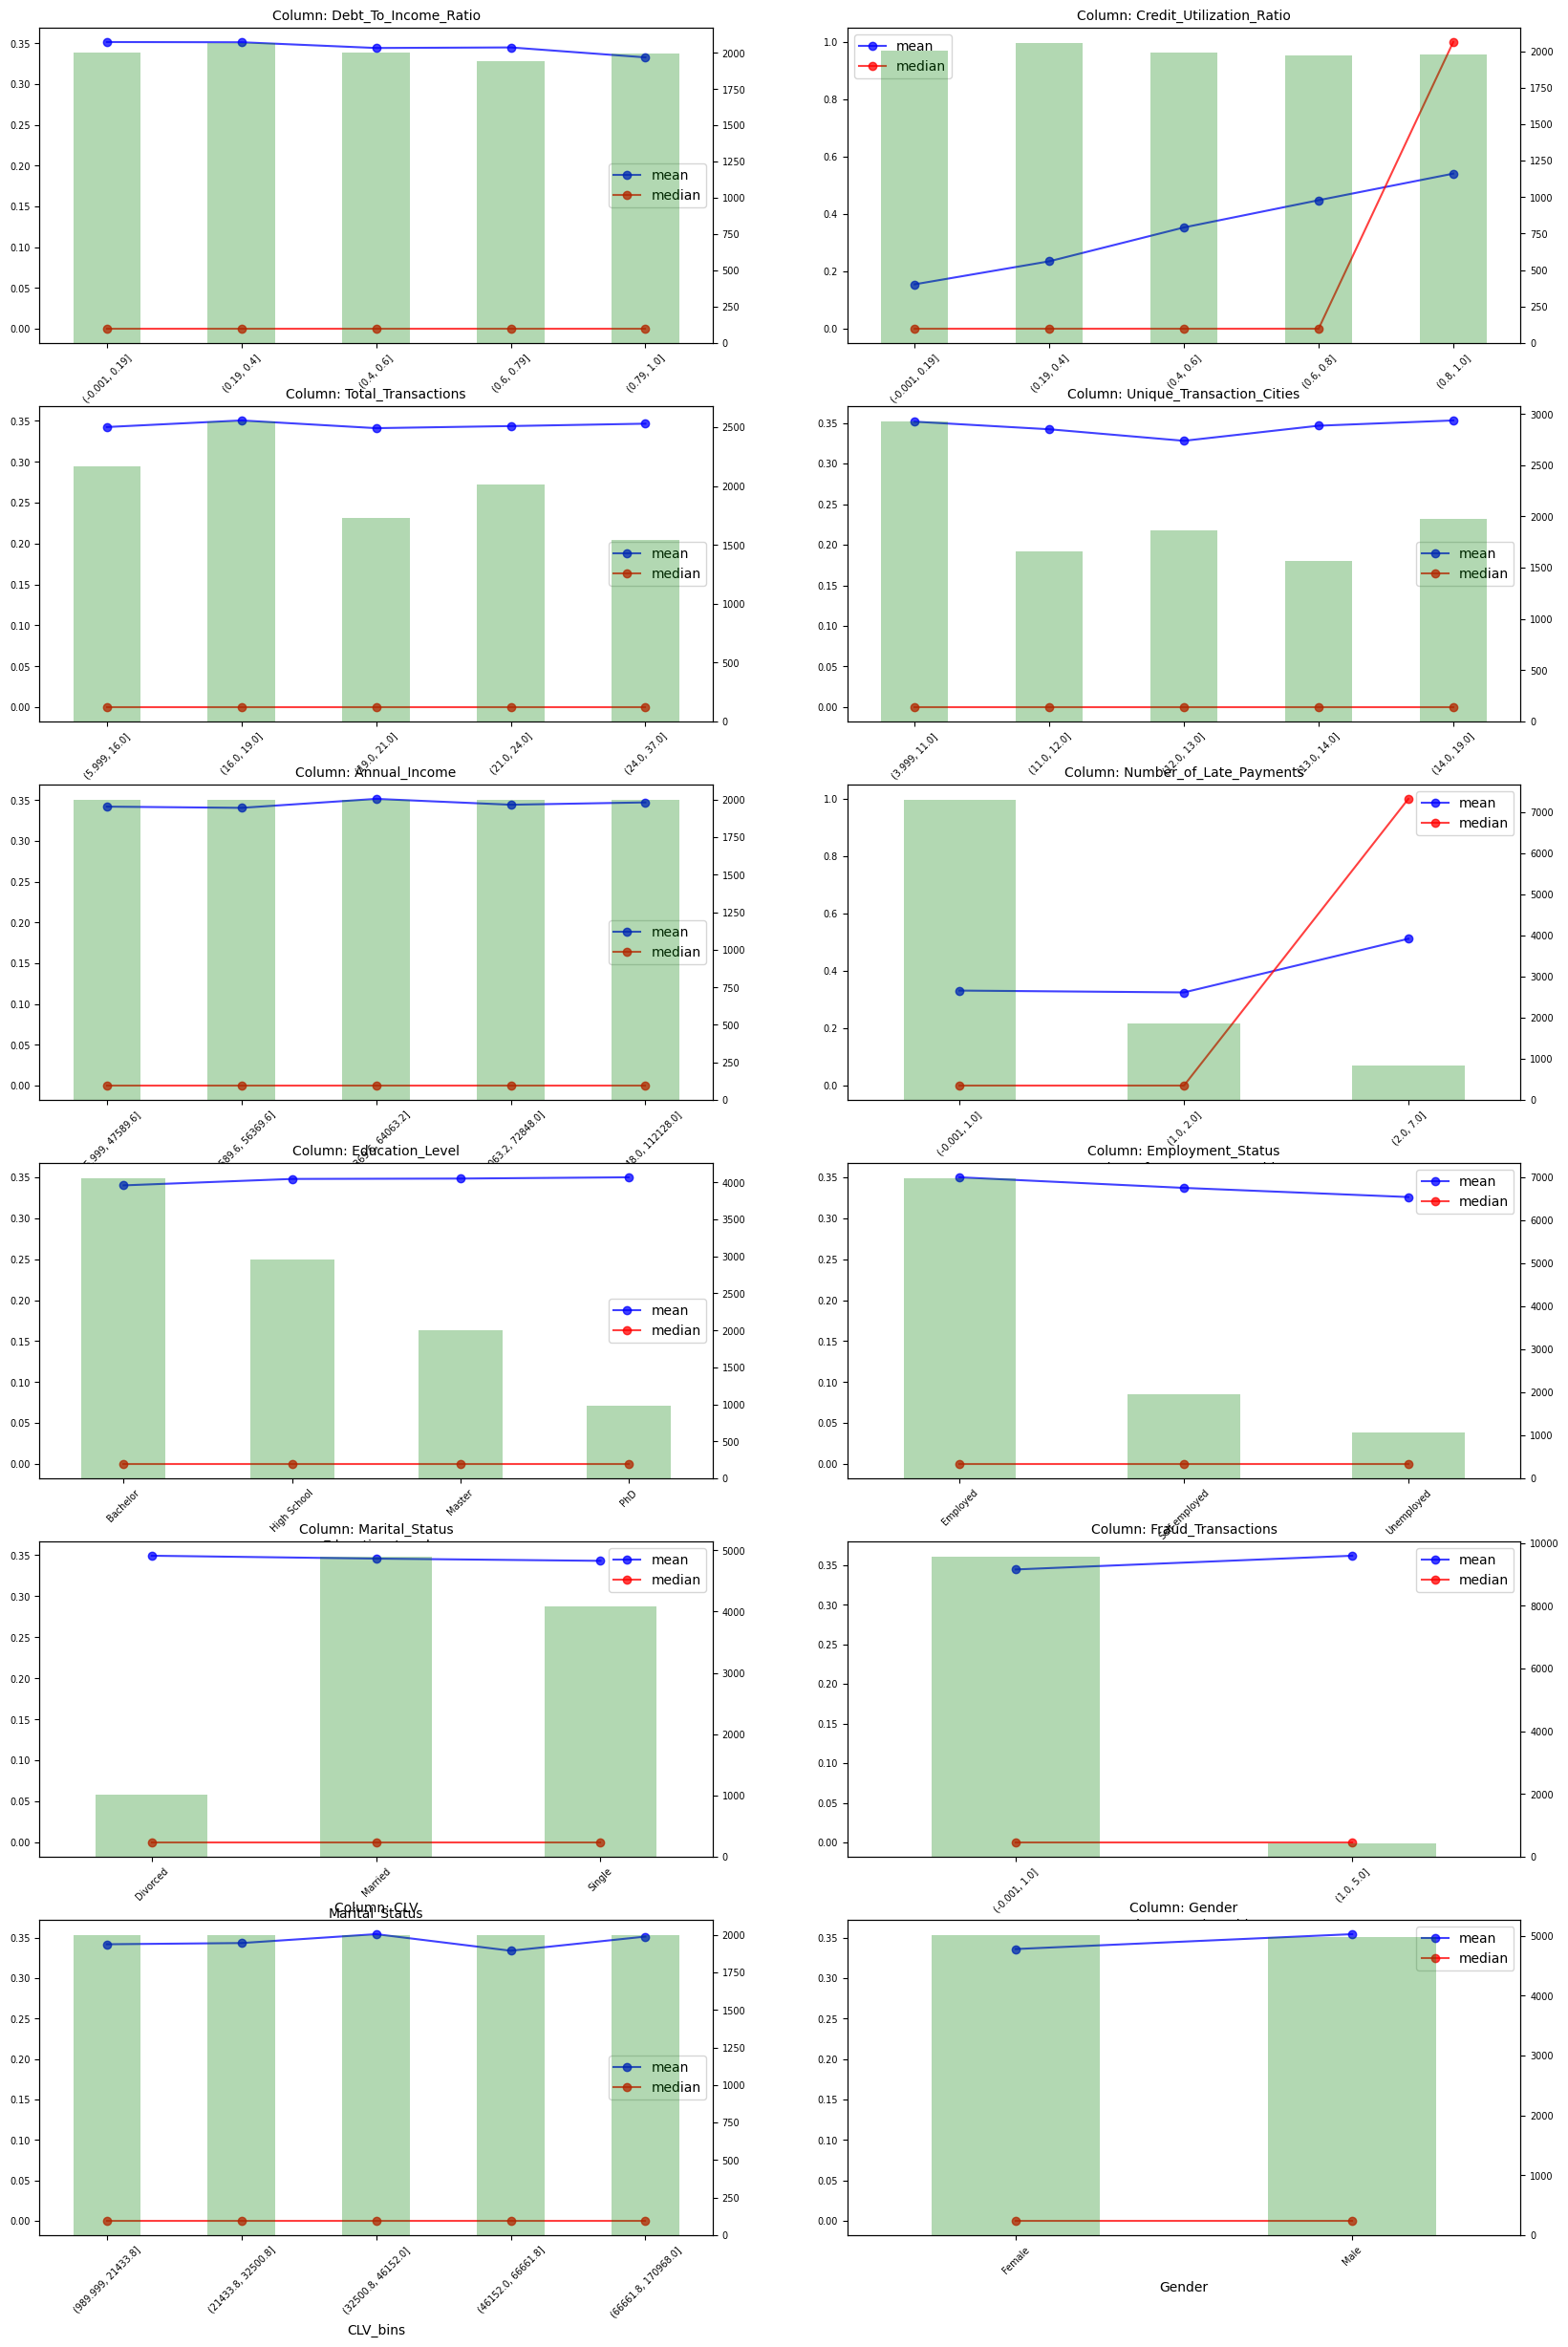

In [8]:
fig,axes=plt.subplots(nrows=6,ncols=2,figsize=(20,30))
cols_to_check=list(set(df.columns).difference(id))
cols_to_check

for index,ax in enumerate(axes.flat, start=0):
    selected_ax=ax

    try:
        column=cols_to_check[index]

    except:
        print(f'Longitud excedida. Índice: {index}. Longitud{len(cols_to_check)}')

        #Eje doble

    rax=selected_ax.twinx()

    if column in objects:
        grouper=column
    else:
        copy[f'{column}_bins']=pd.qcut(df[column],
                                        q=bins,duplicates='drop')#qcut hace dos grupos
        grouper=f'{column}_bins'

    values=copy.groupby(grouper).agg({response_of_interest:['mean','median','count']})[response_of_interest]

    values.index=values.sort_index().index.astype('str')

    values[['mean','median']].plot(ax=selected_ax,rot=45,
                                  color=['blue','red'],
                                  marker='o',
                                  kind='line',
                                  alpha=0.75,
                                  fontsize=7
                                  )
    values['count'].plot(grid=False,kind='bar',ax=rax,alpha=0.3,color='green',fontsize=7)#rax eje derecho

    #Título
    selected_ax.set_title(f'Column: {column}',fontsize=10)

In [9]:
copy=df.copy()
copy.drop(id,axis=1,inplace=True)
categorical_features = copy.select_dtypes(include='object').columns.tolist()
numerical_features = copy.select_dtypes(include=['int64', 'float64']).columns.tolist()

features=copy.drop(response_of_interest,axis=1)
features=features.drop(categorical_features,axis=1)
target=copy[response_of_interest]

X_train,X_test,y_train,y_test=train_test_split(features,target,test_size=0.2,random_state=42)
lr=LogisticRegression()
lr.fit(X_train,y_train)

/Users/karimmetejeda/Documents/MODELOS DE CRÉDITO/Códigos de clases/Modelo-de-cr-dito/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [10]:
y_pred=lr.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, lr.predict_proba(X_test)[:, 1])

print("Model Performance Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"AUC-ROC: {roc_auc:.4f}")

Model Performance Metrics:
Accuracy: 0.6600
Precision: 0.0000
Recall: 0.0000
F1-score: 0.0000
AUC-ROC: 0.5227


/Users/karimmetejeda/Documents/MODELOS DE CRÉDITO/Códigos de clases/Modelo-de-cr-dito/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


In [11]:
copy=df.copy()
# Ordinal Encoding para categoricas de más de dos clases
categorical_cols_multi_class = [col for col in categorical_features if copy[col].nunique() > 2 and col != 'Customer_ID']
# One-Hot encoding para dos clases
categorical_cols_binary = [col for col in categorical_features if copy[col].nunique() == 2 and col != 'Customer_ID']

if categorical_cols_multi_class:
    ordinal_encoder = OrdinalEncoder()
    copy[categorical_cols_multi_class] = ordinal_encoder.fit_transform(copy[categorical_cols_multi_class])

if categorical_cols_binary:
     copy = pd.get_dummies(copy, columns=categorical_cols_binary, drop_first=True)


display(copy.head())

,Customer_ID,Age,Marital_Status,Education_Level,Employment_Status,Annual_Income,Credit_Score,Number_of_Credit_Lines,Credit_Utilization_Ratio,Debt_To_Income_Ratio,...,Defaulted,CLV,Total_Transactions,Avg_Transaction_Amount,Max_Transaction_Amount,Min_Transaction_Amount,Fraud_Transactions,Unique_Merchant_Categories,Unique_Transaction_Cities,Gender_Male
0,CUST_00001,59,1.0,3.0,2.0,41442,642,4,0.44,0.40,...,0,57310,22,454.337273,1379.89,11.83,0,10,13,True
1,CUST_00002,49,0.0,1.0,2.0,85992,665,7,0.52,0.29,...,0,124494,22,378.365000,1939.47,7.00,1,8,13,True
2,CUST_00003,35,1.0,0.0,0.0,58420,683,8,0.88,0.20,...,1,46180,10,437.929000,1712.14,1.92,0,7,9,True
3,CUST_00004,63,2.0,0.0,0.0,59733,674,7,0.40,0.55,...,1,35120,23,540.463913,2095.41,16.57,0,9,15,True
4,CUST_00005,28,1.0,2.0,0.0,69487,733,5,0.88,0.77,...,1,24310,16,520.643750,2068.37,28.06,1,8,12,False


In [12]:
#Regresión Logísitica con Data transformada
#Separamos nuestra data en las características que nos interesan y la variable de respuesta
copy.drop(id,axis=1,inplace=True)
data_features=copy.drop(response_of_interest,axis=1)
data_target=copy[response_of_interest]
# Drop Customer_ID from data_features
if 'Customer_ID' in data_features.columns:
    data_features = data_features.drop('Customer_ID', axis=1)

numerical_features_before_split = data_features.select_dtypes(include=np.number).columns.tolist()
categorical_features_before_split = data_features.select_dtypes(include='object').columns.tolist()

#Separamos la data en train y test
X_train, X_test, y_train, y_test = train_test_split(data_features, data_target, test_size=0.2, random_state=42)


if 'Defaulted' in numerical_features_before_split:
    numerical_features_before_split.remove('Defaulted')


X_train_numerical = X_train[numerical_features_before_split]
X_test_numerical = X_test[numerical_features_before_split]

X_train_categorical = X_train[categorical_features_before_split]
X_test_categorical = X_test[categorical_features_before_split]

#Estandarizamos nuestra data numérica
scaler=StandardScaler()

X_train_scaled_numerical = scaler.fit_transform(X_train_numerical)
X_test_scaled_numerical = scaler.transform(X_test_numerical)


X_train_scaled = np.concatenate((X_train_scaled_numerical, X_train_categorical), axis=1)
X_test_scaled = np.concatenate((X_test_scaled_numerical, X_test_categorical), axis=1)


print("Shape of X_train_scaled:", X_train_scaled.shape)
print("Shape of X_test_scaled:", X_test_scaled.shape)

Shape of X_train_scaled: (8000, 21)
Shape of X_test_scaled: (2000, 21)


In [13]:
#Regresión Logística
lm=LogisticRegression()
lm.fit(X_train_scaled,y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [14]:

y_pred = lm.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, lm.predict_proba(X_test_scaled)[:, 1])

print("Model Performance Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"AUC-ROC: {roc_auc:.4f}")

Model Performance Metrics:
Accuracy: 0.6750
Precision: 0.5355
Recall: 0.3324
F1-score: 0.4102
AUC-ROC: 0.6831


In [15]:
from sklearn.linear_model import Lasso

lasso = Lasso(alpha=0.01)
lasso.fit(X_train_scaled, y_train)

,alpha,0.01
,fit_intercept,True
,precompute,False
,copy_X,True
,max_iter,1000
,tol,0.0001
,warm_start,False
,positive,False
,random_state,None
,selection,'cyclic'


In [16]:
feature_names_scaled = data_features.columns[data_features.columns.isin(numerical_features_before_split)].tolist() + data_features.columns[data_features.columns.isin(categorical_features_before_split)].tolist()
lasso_coefficients = lasso.coef_
feature_coefficients = pd.Series(lasso_coefficients, index=feature_names_scaled)
sorted_coefficients = feature_coefficients.sort_values(ascending=False)
print("Lasso Coefficients (sorted):")
print(sorted_coefficients)

Lasso Coefficients (sorted):
Credit_Utilization_Ratio        0.133673
Number_of_Late_Payments         0.018207
Total_Spend_Last_Year           0.002230
Marital_Status                  0.000000
Age                             0.000000
Annual_Income                   0.000000
Employment_Status              -0.000000
Education_Level                 0.000000
Number_of_Credit_Lines         -0.000000
Tenure_in_Years                 0.000000
Debt_To_Income_Ratio           -0.000000
Total_Transactions_Last_Year   -0.000000
CLV                             0.000000
Min_Transaction_Amount          0.000000
Total_Transactions              0.000000
Avg_Transaction_Amount          0.000000
Max_Transaction_Amount          0.000000
Unique_Merchant_Categories      0.000000
Fraud_Transactions             -0.000000
Unique_Transaction_Cities      -0.000000
Credit_Score                   -0.000993
dtype: float64


In [17]:
selected_features = feature_coefficients[feature_coefficients != 0].index.tolist()
print("Selected Features based on Lasso Coefficients:")
print(selected_features)

Selected Features based on Lasso Coefficients:
['Credit_Score', 'Credit_Utilization_Ratio', 'Number_of_Late_Payments', 'Total_Spend_Last_Year']


In [18]:
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

lr_selected = LogisticRegression()
lr_selected.fit(X_train_selected, y_train)

/Users/karimmetejeda/Documents/MODELOS DE CRÉDITO/Códigos de clases/Modelo-de-cr-dito/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [19]:
y_pred_selected = lr_selected.predict(X_test_selected)

accuracy_selected = accuracy_score(y_test, y_pred_selected)
precision_selected = precision_score(y_test, y_pred_selected)
recall_selected = recall_score(y_test, y_pred_selected)
f1_selected = f1_score(y_test, y_pred_selected)
roc_auc_selected = roc_auc_score(y_test, lr_selected.predict_proba(X_test_selected)[:, 1])

print("Model Performance Metrics (Selected Features):")
print(f"Accuracy: {accuracy_selected:.4f}")
print(f"Precision: {precision_selected:.4f}")
print(f"Recall: {recall_selected:.4f}")
print(f"F1-score: {f1_selected:.4f}")
print(f"AUC-ROC: {roc_auc_selected:.4f}")

Model Performance Metrics (Selected Features):
Accuracy: 0.6835
Precision: 0.5598
Recall: 0.3235
F1-score: 0.4101
AUC-ROC: 0.6855


In [24]:
#Random Forest
classifier = RandomForestClassifier(
    n_estimators=700,              
    max_depth=40,                  
    min_samples_split=10,          
    min_samples_leaf=4,           
    bootstrap=True,              
    oob_score=True,               
    class_weight='balanced',      
    max_samples=0.8,               
    criterion='gini',           
    n_jobs=-1,           
    random_state=42,
    verbose=1,
    warm_start=False
)
classifier.fit(X_train_selected,y_train)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 700 out of 700 | elapsed:    8.6s finished


,n_estimators,700
,criterion,'gini'
,max_depth,40
,min_samples_split,10
,min_samples_leaf,4
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,True


In [25]:
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                              f1_score, roc_auc_score, confusion_matrix,
                              classification_report, roc_curve, auc)

y_pred_rf = classifier.predict(X_test_selected)
y_pred_proba_rf = classifier.predict_proba(X_test_selected)[:, 1]

accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf, zero_division=0)
recall_rf = recall_score(y_test, y_pred_rf, zero_division=0)
f1_rf = f1_score(y_test, y_pred_rf, zero_division=0)
roc_auc_rf = roc_auc_score(y_test, y_pred_proba_rf)

print("\n" + "="*80)
print("MÉTRICAS DE RENDIMIENTO - RANDOM FOREST OPTIMIZADO")
print("="*80)
print(f"Accuracy:  {accuracy_rf:.4f} ({accuracy_rf*100:.2f}%)")
print(f"Precision: {precision_rf:.4f}")
print(f"Recall:    {recall_rf:.4f}")
print(f"F1-Score:  {f1_rf:.4f}")
print(f"AUC-ROC:   {roc_auc_rf:.4f}")
print("="*80)

# Reporte de clasificación detallado
print("\n📊 REPORTE DE CLASIFICACIÓN DETALLADO:\n")
print(classification_report(y_test, y_pred_rf, 
                           target_names=['No Default', 'Default'],
                           digits=4))



[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 700 out of 700 | elapsed:    0.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 700 out of 700 | elapsed:    0.6s finished



MÉTRICAS DE RENDIMIENTO - RANDOM FOREST OPTIMIZADO
Accuracy:  0.6350 (63.50%)
Precision: 0.4672
Recall:    0.5235
F1-Score:  0.4938
AUC-ROC:   0.6666

📊 REPORTE DE CLASIFICACIÓN DETALLADO:

              precision    recall  f1-score   support

  No Default     0.7383    0.6924    0.7146      1320
     Default     0.4672    0.5235    0.4938       680

    accuracy                         0.6350      2000
   macro avg     0.6027    0.6080    0.6042      2000
weighted avg     0.6461    0.6350    0.6395      2000




📈 MATRIZ DE CONFUSIÓN:
Verdaderos Negativos (TN): 915
Falsos Positivos (FP):     405
Falsos Negativos (FN):     318
Verdaderos Positivos (TP): 362


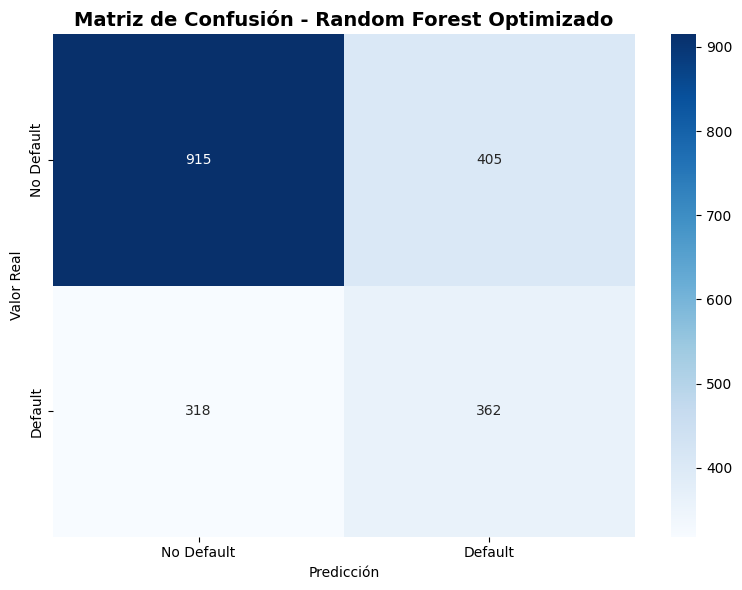

In [22]:
# Matriz de confusión
cm = confusion_matrix(y_test, y_pred_rf)
print("\n📈 MATRIZ DE CONFUSIÓN:")
print(f"Verdaderos Negativos (TN): {cm[0,0]:,}")
print(f"Falsos Positivos (FP):     {cm[0,1]:,}")
print(f"Falsos Negativos (FN):     {cm[1,0]:,}")
print(f"Verdaderos Positivos (TP): {cm[1,1]:,}")

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Default', 'Default'],
            yticklabels=['No Default', 'Default'])
plt.title('Matriz de Confusión - Random Forest Optimizado', 
          fontsize=14, fontweight='bold')
plt.ylabel('Valor Real')
plt.xlabel('Predicción')
plt.tight_layout()
plt.show()


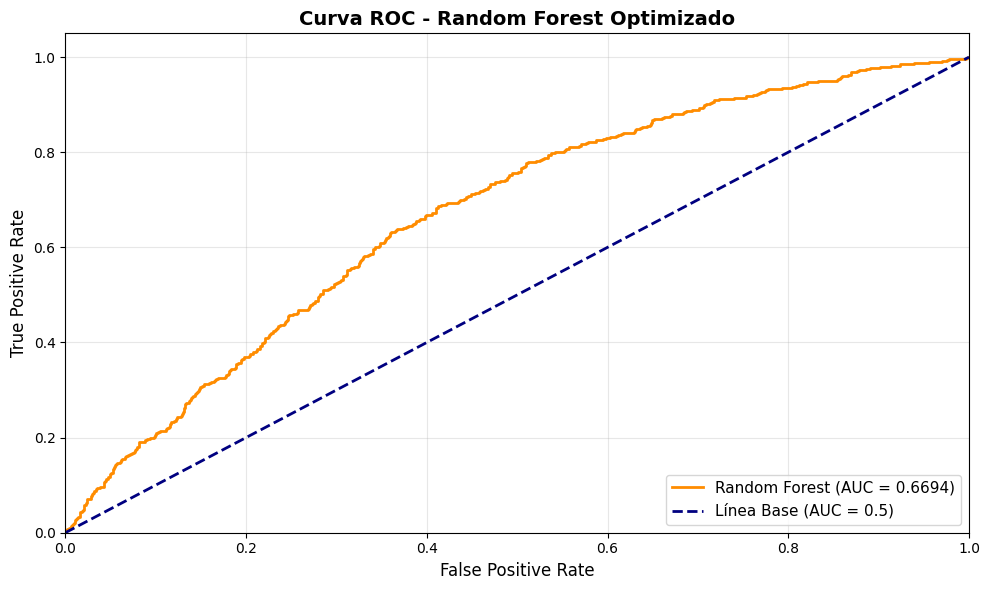

In [23]:
# Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_rf)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, 
         label=f'Random Forest (AUC = {roc_auc_rf:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', 
         label='Línea Base (AUC = 0.5)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Curva ROC - Random Forest Optimizado', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()